In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

import scipy.constants as constants
import scipy.special as special

from qutip import *

%matplotlib ipympl

# Max Fock State
N = 40

## Pure Displacement Operation

A pure and simple displacement operation has the following Hamiltonian form:

$$ H_D = \alpha (a^\dagger + a) $$

Where $\alpha$ refers to the displacement amplitude. This is simple enough to implement in QuTip, as shown below:

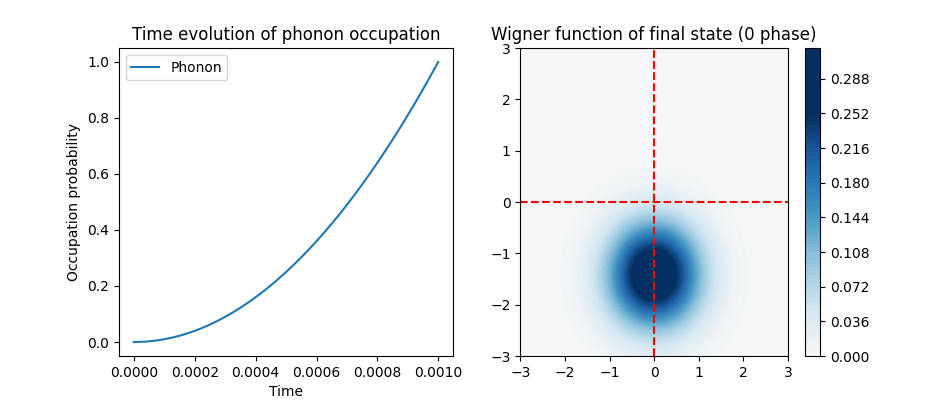

In [2]:
alpha = 1 * 10**(3) # Displacement amplitude. This is just a random value such that we see something significant at the time scales we are concerned about.

# ---------- Define Operators ---------- #
a = tensor(destroy(N))

H = alpha * (a.dag() + a) # Usual Displacement Hamiltonian

# ---------- Initial State ---------- #
psi0 = tensor(basis(N, 0))  # Initialise in Fock |0> state.

# ---------- Time Evolution ----------#
t = np.linspace(0, 1.0 * 10**(-3), 1001)

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a])
n_c = output.expect[0]

# ---------- Plot Phonon population as function of evolution time ----------#
fig, axes = plt.subplots(1, 2, figsize=(9.5, 4))
axes[0].plot(t, n_c, label="Phonon")
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Occupation probability")
axes[0].set_title("Time evolution of phonon occupation")

# ---------- Plot Wigner Function at the end of the evolution ----------#
output = mesolve(H = H, rho0 = psi0, tlist = t)
rho = output.states[-1]

xvec = np.linspace(-3, 3, 200)
W = wigner(rho, xvec, xvec)

axes[1].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[1].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes[1].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[1].set_title("Wigner function of final state (0 phase)")
plt.colorbar(im)

Notice how the axis of displacement changes when the phase of the Hamiltonian is changed from $0$ to $\pi/2$

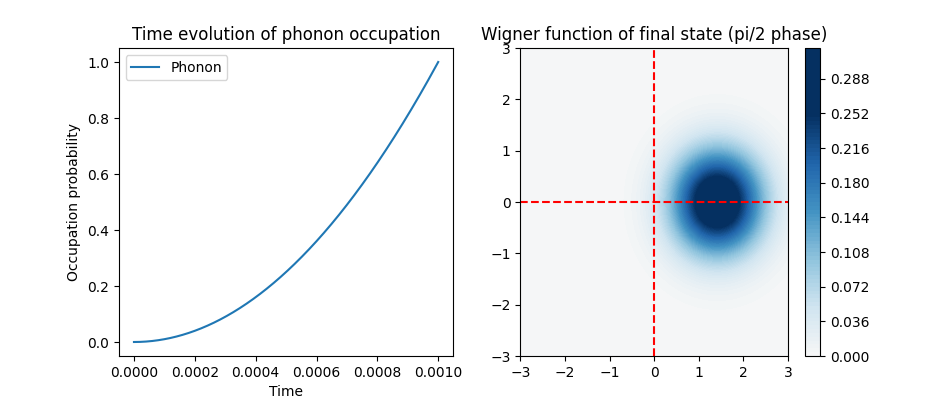

In [3]:
H = alpha * (a.dag() + a) * 1j # Pi/2 phase

# ---------- Initial State ---------- #
psi0 = tensor(basis(N, 0))  # Initialise in Fock |0> state.

# ---------- Time Evolution ----------#
t = np.linspace(0, 1.0 * 10**(-3), 1001)

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a])
n_c = output.expect[0]

# ---------- Plot Phonon population as function of evolution time ----------#
fig, axes = plt.subplots(1, 2, figsize=(9.5, 4))
axes[0].plot(t, n_c, label="Phonon")
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Occupation probability")
axes[0].set_title("Time evolution of phonon occupation")

# ---------- Plot Wigner Function at the end of the evolution ----------#
output = mesolve(H = H, rho0 = psi0, tlist = t)
rho = output.states[-1]

xvec = np.linspace(-3, 3, 200)
W = wigner(rho, xvec, xvec)

axes[1].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[1].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes[1].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[1].set_title("Wigner function of final state (pi/2 phase)")
plt.colorbar(im)

How does this displaced state then freely evolve in phase space?

/tmp/ipykernel_25701/3756073629.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  ims.append(im.collections)


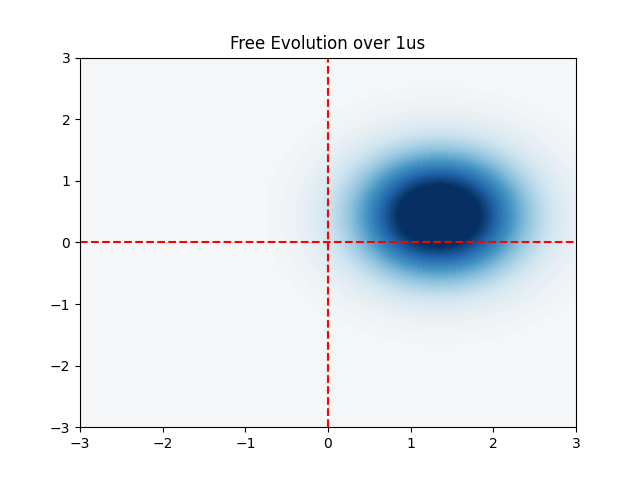

In [4]:
omega = 2 * np.pi * 1.000 * 10**6 # Energy of the harmonic oscillator is 1MHz (to be approximately a motional mode frequency)

H = omega * (a.dag() * a + 1/2)

# ---------- Initial State ---------- #
psi_free_evolve = rho # Final state after displacement

# ---------- Time Evolution ----------#
t = np.linspace(0, 1.0 * 10**(-6), 101)

output = mesolve(H = H, rho0 = psi_free_evolve, tlist = t, e_ops = [a.dag() * a])
n_c = output.expect[0]

# ---------- Plot Wigner Function at different points of evolution ----------#
output = mesolve(H = H, rho0 = psi_free_evolve, tlist = t)
rho = output.states[-1]

fig, axes = plt.subplots()
xvec = np.linspace(-3, 3, 200)
W = wigner(rho, xvec, xvec)

axes.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes.set_title("Free Evolution over 1us")

index = [i * 5 for i in range(20)]

ims = []
for i in index:
    W = wigner(output.states[i], xvec, xvec)
    im = axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ims.append(im.collections)

#plt.colorbar(im)
ani = animation.ArtistAnimation(fig, ims, interval = 200, repeat = True)
plt.show()

We observe a rotation of the coherent state about the origin of phase space. This is what we expect given the free evolution of a coherent state:

$$ \ket{\psi}(t) = e^{-i\omega t/2}\ket{\alpha e^{-i\omega t}} $$

The global phase factor has no impact, but the internal phase of $e^{-i\omega t}$ means that the state will rotate about the origin at a frequency equal to the frequency of the harmonic oscillator itself.

## Displacement Operation Using Trapped Ions

In [5]:
def eval_rabi_freq(nStart, nDelta, eta):
    """
    Calculates Rabi Frequency for nStart -> nStart + nDelta

    Args:
        nStart (int): Initial phonon state
        nDelta (int): Change in phonon number
        eta (float): Lamb-Dicke Parameter

    Returns:
        float: Rabi frequency
    """
    nEnd = nStart + nDelta

    nSmall = min([nStart, nEnd])
    nBig = max([nStart, nEnd])
    factor2 = np.exp(-0.5 * eta**2) * eta**(np.absolute(nDelta))
    factor3 = np.sqrt(np.math.factorial(nSmall)/np.math.factorial(nBig))
    factor4 = special.assoc_laguerre(eta**2, nSmall, np.absolute(nDelta))

    return factor2 * factor3 * factor4

In [6]:
# ---------- Experimental Parameters ---------- #
tpi = 10 * 10**(-6) # Pi time of carrier
# We have modified this value such that we don't run into problems with the maximum Fock state.
# Longer tpi allows for smaller displacements, which keep calculations managable
ld_param = 0.2

rabi_freq = np.pi / tpi

# ---------- Operators ---------- #
a = tensor(qeye(2), destroy(N))
sm = tensor(destroy(2), qeye(N))
sz = tensor(sigmaz(), qeye(N))

We compare and contrast three different versions of the displacement Hamiltonian for a trapped ion.

1) RSB + BSB interaction only
2) Fourth-order expansion to Lamb-Dicke parameter w/o RWA
3) Fourth-order Hamiltonian without small Lamb-Dicke parameter approximation

#### 1) RSB + BSB Interactions Only

Here, the relevant Hamiltonians (on resonance) are:

$$ H_{rsb} = \frac{\Omega_{1,0}}{2} (\hat{a} \sigma_+ e^{i\phi} + \hat{a}^\dagger \sigma_- e^{-i \phi})$$
$$ H_{bsb} = \frac{\Omega_{0,1}}{2} (\hat{a}^\dagger \sigma_+ e^{i\phi} + \hat{a} \sigma_- e^{-i\phi})$$

To obtain the displacement operation from these two Hamiltonians, we need to set $\phi = 0$ such that:

$$ H_{rsb} = \frac{\Omega_{1,0}}{2} (\hat{a} \sigma_+ + \hat{a}^\dagger \sigma_-)$$
$$ H_{bsb} = \frac{\Omega_{0,1}}{2} (\hat{a}^\dagger \sigma_+ + \hat{a} \sigma_-)$$

Since $\Omega_{1,0} = \Omega_{0,1}$, we have the total Hamiltonian of:

$$ H_{totaal} = \frac{\Omega_{1,0}}{2} (\hat{a} \sigma_+ + \hat{a}^\dagger \sigma_- + \hat{a}^\dagger \sigma_+ + \hat {a} \sigma_-) = \frac{\Omega_{1,0}}{2} [\sigma_+ (\hat{a} + \hat{a}^\dagger) + \sigma_- (\hat{a} + \hat{a}^\dagger)] = \frac{\Omega_{1,0}}{2} (\hat{a} + \hat{a}^\dagger) (\sigma_+ + \sigma_-) = \frac{\Omega_{1,0}}{2} \sigma_x (\hat{a} + \hat{a}^\dagger)$$

Meaning that the displacement operator works in the SigmaX basis. As such, our initial spin state has to be in an eigenstate of the SigmaX Pauli matrix for a definite displacement direction. 

Let us confirm this with QuTip:

/tmp/ipykernel_25701/1848707629.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  factor3 = np.sqrt(np.math.factorial(nSmall)/np.math.factorial(nBig))


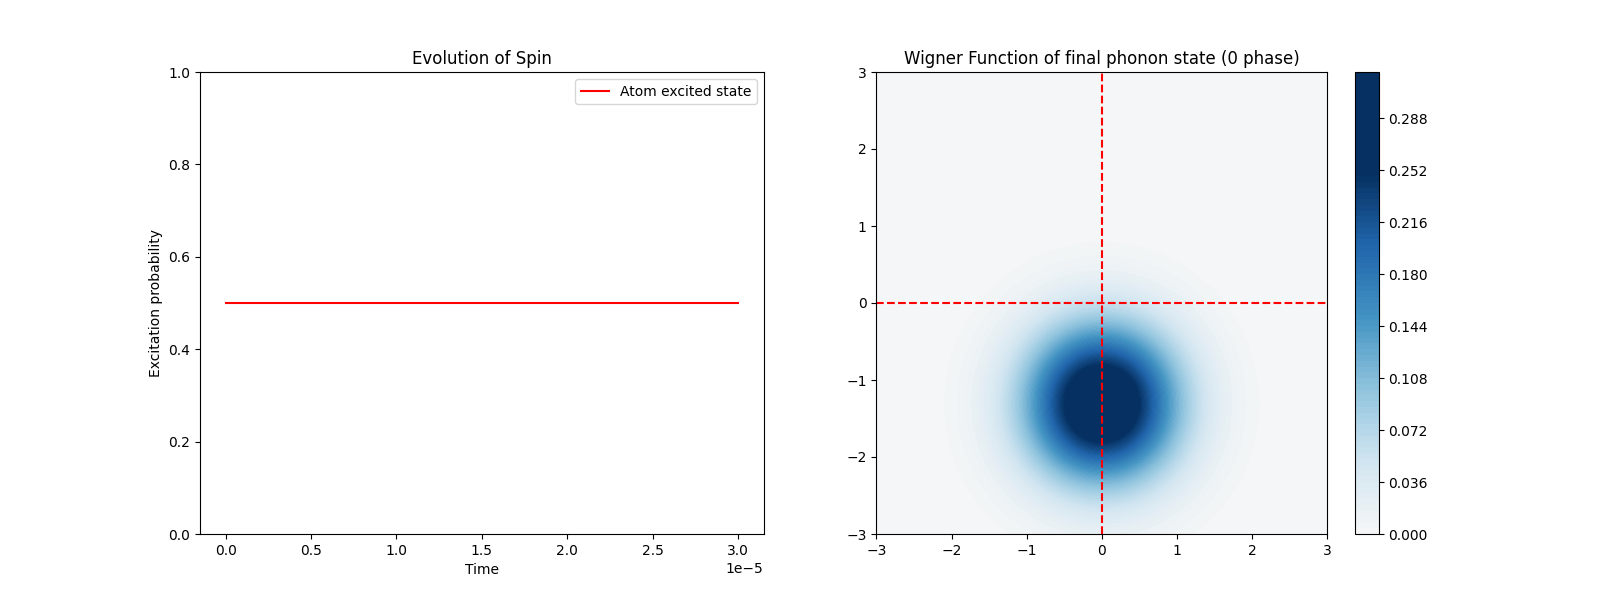

In [12]:
# ---------- Parameters ---------- #
rsb_rabi_freq = rabi_freq * eval_rabi_freq(1, -1, ld_param)
bsb_rabi_freq = rabi_freq * eval_rabi_freq(0, 1, ld_param)

rsb_phase = 0
bsb_phase = 0

# ---------- Hamiltonians ---------- #
# Subscript p refers to the Hermitian Conjugate
RSB = (rsb_rabi_freq / 2) * a * sm.dag() * np.exp(1j * rsb_phase)
RSBp = (rsb_rabi_freq / 2) * a.dag() * sm * np.exp(-1j * rsb_phase)

BSB = (bsb_rabi_freq / 2) * a.dag() * sm.dag() * np.exp(1j * bsb_phase)
BSBp = (bsb_rabi_freq / 2) * a * sm * np.exp(-1j * bsb_phase)

# ---------- Time Evolution ----------#
t = np.linspace(0, 30 * 10**(-6), 1001)

H = [RSB, RSBp, BSB, BSBp]

# ---------- Initial State ---------- #
psi0 = tensor(np.sqrt(2) * (basis(2,0) + basis(2,1)), basis(N, 0))  # Initialise in |+> |0> state.

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm])
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(t, n_a, 'r-', label="Atom excited state")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Excitation probability")
axes[0].set_title("Evolution of Spin")

# Pi-time is where phonon population is maximum
tt = np.where(n_c == max(n_c))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t)
rho_check = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon_check = ptrace(rho_check, 1)
W = wigner(rho_phonon_check, xvec, xvec)

im = axes[1].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[1].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[1].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[1].set_title("Wigner Function of final phonon state (0 phase)")
plt.colorbar(im)

As we expected, starting with a |+>|0> state results in a coherent displacement of the ground motional state into a coherent displaced state. Because we are working in the correct spin basis, we see no evolution in the spin state at all, while the phonon state does evolve with time.

Setting $\phi = \pi$ will result in the state being displaced into the positive momentum instead, which is as expected. However, what happens if we set $\phi = \pi/2?$ Does the state get displaced in the position axes instead, like we saw for the pure displacement operation above?

/tmp/ipykernel_25701/1848707629.py:18: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  factor3 = np.sqrt(np.math.factorial(nSmall)/np.math.factorial(nBig))


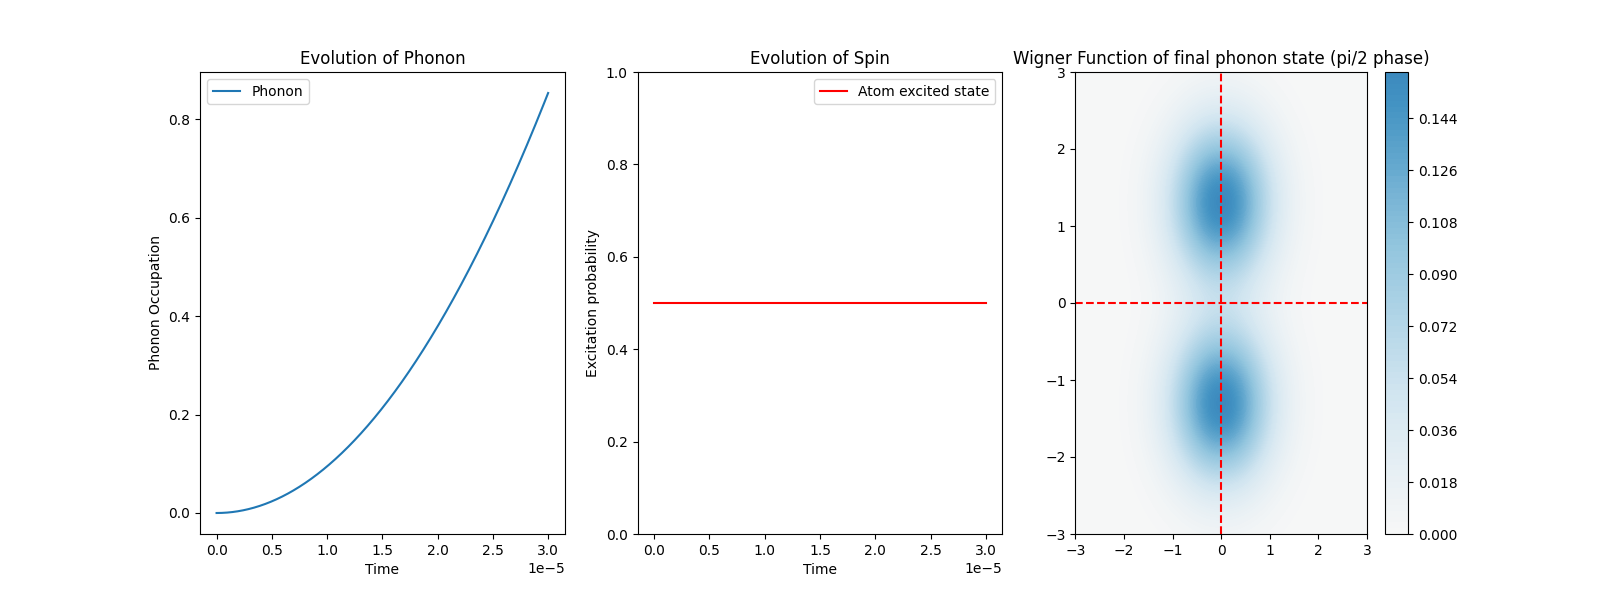

In [13]:
# ---------- Parameters ---------- #
rsb_rabi_freq = rabi_freq * eval_rabi_freq(1, -1, ld_param)
bsb_rabi_freq = rabi_freq * eval_rabi_freq(0, 1, ld_param)

rsb_phase = np.pi/2 # Phase is now pi/2
bsb_phase = np.pi/2

# ---------- Hamiltonians ---------- #
# Subscript p refers to the Hermitian Conjugate
RSB = (rsb_rabi_freq / 2) * a * sm.dag() * np.exp(1j * rsb_phase)
RSBp = (rsb_rabi_freq / 2) * a.dag() * sm * np.exp(-1j * rsb_phase)

BSB = (bsb_rabi_freq / 2) * a.dag() * sm.dag() * np.exp(1j * bsb_phase)
BSBp = (bsb_rabi_freq / 2) * a * sm * np.exp(-1j * bsb_phase)

# ---------- Time Evolution ----------#
t = np.linspace(0, 30 * 10**(-6), 1001)

H = [RSB, RSBp, BSB, BSBp]

# ---------- Initial State ---------- #
psi0 = tensor(np.sqrt(2) * (basis(2,0) + basis(2,1)), basis(N, 0))  # Initialise in |+> |0> state.

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm])
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes[0].plot(t, n_c, label="Phonon")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Phonon Occupation")
axes[0].set_title("Evolution of Phonon")

axes[1].plot(t, n_a, 'r-', label="Atom excited state")
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Excitation probability")
axes[1].set_title("Evolution of Spin")

# Pi-time is where phonon population is maximum
tt = np.where(n_c == max(n_c))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t)
rho_check = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon_check = ptrace(rho_check, 1)
W = wigner(rho_phonon_check, xvec, xvec)

im = axes[2].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[2].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[2].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[2].set_title("Wigner Function of final phonon state (pi/2 phase)")
plt.colorbar(im)

Instead of the state being displaced in the position axes, we see that the state is displaced into both the positive and negative momentum axes. The reason is actually quite simple.

For $\phi = \pi/2$, the spin basis for the Hamiltonian can be worked out to be the $\sigma_y$ Puali matrix instead. This means that for our initial state of $\ket{+} = \sqrt{\frac{1}{2}}(\ket{i} + \ket{-i})$ (where $\ket{\pm i}$ are the eigenstates of $\sigma_y$), half the population gets pushed in the positive momentum axis while the other half gets pushed in the negative momentum axis.

Since our spin measurement basis is in $\sigma_z$ however, the spin time-evolution looks to be no different from the case where $\phi = \pi$.

#### 2) Fourth-order expansion to Lamb-Dicke parameter w/o RWA

For this case, we start not from the on-resonance condition (and thus the nice and neat RSB and BSB Hamiltonians), but from the general expansion of the ion-light interaction Hamiltonian:

$$ H(t) = \frac{\Omega_{n, n+s}}{2} \sigma_+ [1 + i\eta (\hat{a} e^{-i\omega_m t} + \hat{a}^\dagger e^{i \omega_m t})] e^{-i\delta t} e^{i\phi} + \cdots + H.C. $$

We write out the expansion to the fourth order and simply right out all these terms in QuTip directly. However, like the previous case where we had both RSB and BSB interactions on resonance, we also need two seperate laser beams here as well. The two lasers will have different detunings (one on resonance to the BSB and one on resonance to the RSB), as well as two different phases. These two Hamiltonians resulting from the two lasers are independent, and can be added linearly. 

We choose $\phi_1 = \phi_2 = \pi/2$ for convenience. This choice will result in the Hamiltonian being in the $\sigma_x$ basis once again, which is consistent with the previous case, and more importantly is the spin basis we work with during experiments.

In [14]:
# ---------- Hamiltonians ---------- #
# If you want to see the full derivation plase refer to my Derivation notes

# Carrier Terms (Detuning 1)
a_0 = (rabi_freq / 2) * sm.dag()
def aoeff_0(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_0p = (rabi_freq / 2) * sm
def aoeff_0p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

# First-Order Terms (Detuning 1)
a_11 = 1j * (rabi_freq / 2) * ld_param * sm.dag() * a
def aoeff_11(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)
a_11p = -1j * (rabi_freq / 2) * ld_param * sm * a.dag()
def aoeff_11p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)

a_12 = 1j* (rabi_freq / 2) * ld_param * sm.dag() * a.dag()
def aoeff_12(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)
a_12p = -1j* (rabi_freq / 2) * ld_param * sm * a
def aoeff_12p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)

# Second-Order Terms (Detuning 1)
a_21 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * a**2
def aoeff_21(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-2 * 1j * args['mode_freq'] * t)
a_21p = -(rabi_freq / 2) * ld_param**2 * sm * a.dag()**2
def aoeff_21p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-2 * -1j * args['mode_freq'] * t)

a_22 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * 2 * a * a.dag()
def aoeff_22(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_22p = -(rabi_freq / 2) * ld_param**2 * sm * 2 * a * a.dag()
def aoeff_22p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

a_23 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * a.dag()**2
def aoeff_23(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(2 * 1j * args['mode_freq'] * t)
a_23p = -(rabi_freq / 2) * ld_param**2 * sm * a**2
def aoeff_23p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(2 * -1j * args['mode_freq'] * t)

a_24 = -(rabi_freq / 2) * ld_param**2 * sm.dag()
def aoeff_24(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_24p = -(rabi_freq / 2) * ld_param**2 * sm
def aoeff_24p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

# Third-Order Terms (Detuning 1)
a_31 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * a**3
def aoeff_31(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-3 * 1j * args['mode_freq'] * t)
a_31p = 1j * (rabi_freq / 2) * ld_param**3 * sm * a.dag()**3
def aoeff_31p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-3 * -1j * args['mode_freq'] * t)

a_32 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a**2 * a.dag()
def aoeff_32(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)
a_32p = 1j * (rabi_freq / 2) * ld_param**3 * sm * 3 * a * a.dag()**2
def aoeff_32p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)

a_33 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a.dag()**2 * a
def aoeff_33(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)
a_33p = 1j * (rabi_freq / 2) * ld_param**3 * sm* 3 * a.dag() * a**2
def aoeff_33p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)

a_34 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * a.dag()**3
def aoeff_34(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(3 * 1j * args['mode_freq'] * t)
a_34p = 1j * (rabi_freq / 2) * ld_param**3 * sm * a**3
def aoeff_34p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(3 * -1j * args['mode_freq'] * t)

a_35 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * -3 * a
def aoeff_35(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)
a_35p = 1j * (rabi_freq / 2) * ld_param**3 * sm * -3 * a.dag()
def aoeff_35p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)

a_36 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a.dag()
def aoeff_36(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(1j * args['mode_freq'] * t)
a_36p = 1j * (rabi_freq / 2) * ld_param**3 * sm * 3 * a
def aoeff_36p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-1j * args['mode_freq'] * t)

# Fourth-Order Terms (Detuning 1)
a_41 = (rabi_freq / 2) * ld_param**4 * sm.dag() * a**4
def aoeff_41(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-4 * 1j * args['mode_freq'] * t)
a_41p = (rabi_freq / 2) * ld_param**4 * sm * a.dag()**4
def aoeff_41p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-4 * -1j * args['mode_freq'] * t)

a_42 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 4 * a**3 * a.dag()
def aoeff_42(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-2 * 1j * args['mode_freq'] * t)
a_42p = (rabi_freq / 2) * ld_param**4 * sm * 4 * a * a.dag()**3
def aoeff_42p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-2 * -1j * args['mode_freq'] * t)

a_43 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 6 * a.dag()**2 * a**2
def aoeff_43(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_43p = (rabi_freq / 2) * ld_param**4 * sm * 6 * a.dag()**2 * a**2
def aoeff_43p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

a_44 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 4 * a.dag()**3 * a
def aoeff_44(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(2 * 1j * args['mode_freq'] * t)
a_44p = (rabi_freq / 2) * ld_param**4 * sm * 4 * a.dag() * a**3
def aoeff_44p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(2 * -1j * args['mode_freq'] * t)

a_45 = (rabi_freq / 2) * ld_param**4 * sm.dag() * a.dag()**4
def aoeff_45(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(4 * 1j * args['mode_freq'] * t)
a_45p = (rabi_freq / 2) * ld_param**4 * sm* a**4
def aoeff_45p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(4 * -1j * args['mode_freq'] * t)

a_46 = (rabi_freq / 2) * ld_param**4 * sm.dag() * -6 * a**2
def aoeff_46(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(-2 * 1j * args['mode_freq'] * t)
a_46p = (rabi_freq / 2) * ld_param**4 * sm * -6 * a.dag()**2
def aoeff_46p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(-2 * -1j * args['mode_freq'] * t)

a_47 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 6 * a.dag()**2
def aoeff_47(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * np.exp(2 * 1j * args['mode_freq'] * t)
a_47p = (rabi_freq / 2) * ld_param**4 * sm * 6 * a**2
def aoeff_47p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * np.exp(2 * -1j * args['mode_freq'] * t)

a_48 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 12 * a * a.dag()
def aoeff_48(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_48p = (rabi_freq / 2) * ld_param**4 * sm * 12 * a * a.dag()
def aoeff_48p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

a_49 = (rabi_freq / 2) * ld_param**4 * sm.dag() * -9
def aoeff_49(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
a_49p = (rabi_freq / 2) * ld_param**4 * sm * -9
def aoeff_49p(t, args):    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

In [15]:
# ---------- Hamiltonians ---------- #
# Carrier Terms (detuning2)
b_0 = (rabi_freq / 2) * sm.dag()
def boeff_0(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_0p = (rabi_freq / 2) * sm
def boeff_0p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

# First-Order Terms (detuning2)
b_11 = 1j * (rabi_freq / 2) * ld_param * sm.dag() * a
def boeff_11(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)
b_11p = -1j * (rabi_freq / 2) * ld_param * sm * a.dag()
def boeff_11p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)

b_12 = 1j* (rabi_freq / 2) * ld_param * sm.dag() * a.dag()
def boeff_12(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)
b_12p = -1j* (rabi_freq / 2) * ld_param * sm * a
def boeff_12p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)

# Second-Order Terms (detuning2)
b_21 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * a**2
def boeff_21(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-2 * 1j * args['mode_freq'] * t)
b_21p = -(rabi_freq / 2) * ld_param**2 * sm * a.dag()**2
def boeff_21p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-2 * -1j * args['mode_freq'] * t)

b_22 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * 2 * a * a.dag()
def boeff_22(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_22p = -(rabi_freq / 2) * ld_param**2 * sm * 2 * a * a.dag()
def boeff_22p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

b_23 = -(rabi_freq / 2) * ld_param**2 * sm.dag() * a.dag()**2
def boeff_23(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(2 * 1j * args['mode_freq'] * t)
b_23p = -(rabi_freq / 2) * ld_param**2 * sm * a**2
def boeff_23p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(2 * -1j * args['mode_freq'] * t)

b_24 = -(rabi_freq / 2) * ld_param**2 * sm.dag()
def boeff_24(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_24p = -(rabi_freq / 2) * ld_param**2 * sm
def boeff_24p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

# Third-Order Terms (detuning2)
b_31 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * a**3
def boeff_31(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-3 * 1j * args['mode_freq'] * t)
b_31p = 1j * (rabi_freq / 2) * ld_param**3 * sm * a.dag()**3
def boeff_31p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-3 * -1j * args['mode_freq'] * t)

b_32 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a**2 * a.dag()
def boeff_32(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)
b_32p = 1j * (rabi_freq / 2) * ld_param**3 * sm * 3 * a * a.dag()**2
def boeff_32p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)

b_33 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a.dag()**2 * a
def boeff_33(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)
b_33p = 1j * (rabi_freq / 2) * ld_param**3 * sm* 3 * a.dag() * a**2
def boeff_33p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)

b_34 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * a.dag()**3
def boeff_34(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(3 * 1j * args['mode_freq'] * t)
b_34p = 1j * (rabi_freq / 2) * ld_param**3 * sm * a**3
def boeff_34p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(3 * -1j * args['mode_freq'] * t)

b_35 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * -3 * a
def boeff_35(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)
b_35p = 1j * (rabi_freq / 2) * ld_param**3 * sm * -3 * a.dag()
def boeff_35p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)

b_36 = -1j * (rabi_freq / 2) * ld_param**3 * sm.dag() * 3 * a.dag()
def boeff_36(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(1j * args['mode_freq'] * t)
b_36p = 1j * (rabi_freq / 2) * ld_param**3 * sm * 3 * a
def boeff_36p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-1j * args['mode_freq'] * t)

# Fourth-Order Terms (detuning2)
b_41 = (rabi_freq / 2) * ld_param**4 * sm.dag() * a**4
def boeff_41(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-4 * 1j * args['mode_freq'] * t)
b_41p = (rabi_freq / 2) * ld_param**4 * sm * a.dag()**4
def boeff_41p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-4 * -1j * args['mode_freq'] * t)

b_42 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 4 * a**3 * a.dag()
def boeff_42(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-2 * 1j * args['mode_freq'] * t)
b_42p = (rabi_freq / 2) * ld_param**4 * sm * 4 * a * a.dag()**3
def boeff_42p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-2 * -1j * args['mode_freq'] * t)

b_43 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 6 * a.dag()**2 * a**2
def boeff_43(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_43p = (rabi_freq / 2) * ld_param**4 * sm * 6 * a.dag()**2 * a**2
def boeff_43p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

b_44 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 4 * a.dag()**3 * a
def boeff_44(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(2 * 1j * args['mode_freq'] * t)
b_44p = (rabi_freq / 2) * ld_param**4 * sm * 4 * a.dag() * a**3
def boeff_44p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(2 * -1j * args['mode_freq'] * t)

b_45 = (rabi_freq / 2) * ld_param**4 * sm.dag() * a.dag()**4
def boeff_45(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(4 * 1j * args['mode_freq'] * t)
b_45p = (rabi_freq / 2) * ld_param**4 * sm* a**4
def boeff_45p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(4 * -1j * args['mode_freq'] * t)

b_46 = (rabi_freq / 2) * ld_param**4 * sm.dag() * -6 * a**2
def boeff_46(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(-2 * 1j * args['mode_freq'] * t)
b_46p = (rabi_freq / 2) * ld_param**4 * sm * -6 * a.dag()**2
def boeff_46p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(-2 * -1j * args['mode_freq'] * t)

b_47 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 6 * a.dag()**2
def boeff_47(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * np.exp(2 * 1j * args['mode_freq'] * t)
b_47p = (rabi_freq / 2) * ld_param**4 * sm * 6 * a**2
def boeff_47p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * np.exp(2 * -1j * args['mode_freq'] * t)

b_48 = (rabi_freq / 2) * ld_param**4 * sm.dag() * 12 * a * a.dag()
def boeff_48(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_48p = (rabi_freq / 2) * ld_param**4 * sm * 12 * a * a.dag()
def boeff_48p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

b_49 = (rabi_freq / 2) * ld_param**4 * sm.dag() * -9
def boeff_49(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
b_49p = (rabi_freq / 2) * ld_param**4 * sm * -9
def boeff_49p(t, args):    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

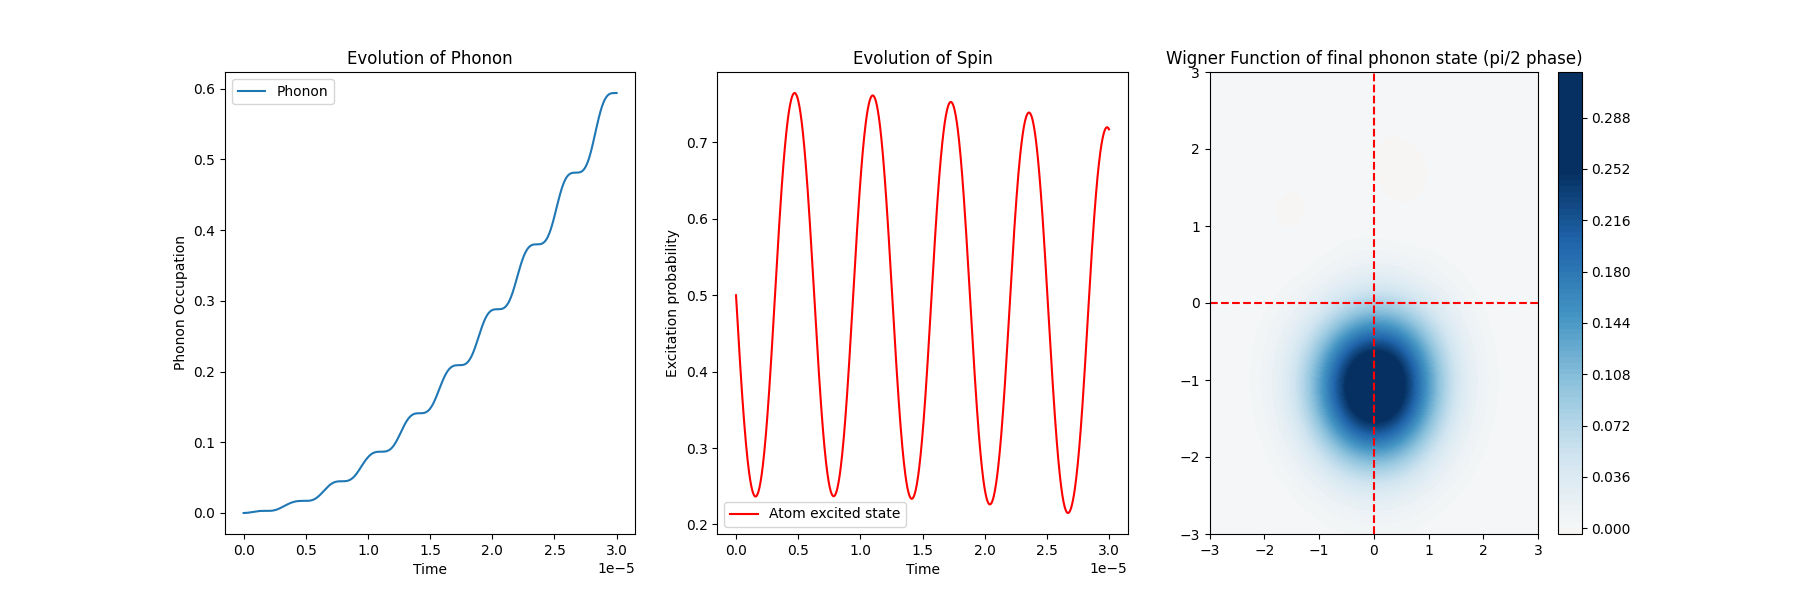

In [16]:
# ---------- Time Evolution ----------#
t = np.linspace(0, 30 * 10**(-6), 1001)

H = [[a_0, aoeff_0], [a_0p, aoeff_0p],
     [a_11, aoeff_11], [a_11p, aoeff_11p], [a_12, aoeff_12], [a_12p, aoeff_12p],
     [a_21, aoeff_21], [a_21p, aoeff_21p], [a_22, aoeff_22], [a_22p, aoeff_22p], [a_23, aoeff_23], [a_23p, aoeff_23p], [a_24, aoeff_24], [a_24p, aoeff_24p],
     [a_31, aoeff_31], [a_31p, aoeff_31p], [a_32, aoeff_31], [a_32p, aoeff_32p], [a_33, aoeff_33], [a_33p, aoeff_33p], [a_34, aoeff_34], [a_34p, aoeff_34p], [a_35, aoeff_35], [a_35p, aoeff_35p], [a_36, aoeff_36], [a_36p, aoeff_36p],
     [a_41, aoeff_41], [a_41p, aoeff_41p], [a_42, aoeff_42], [a_42p, aoeff_42p], [a_43, aoeff_43], [a_43p, aoeff_43p], [a_44, aoeff_44], [a_44p, aoeff_44p], [a_45, aoeff_45], [a_45p, aoeff_35p], [a_46, aoeff_46], [a_46p, aoeff_46p], [a_47, aoeff_46], [a_47p, aoeff_47p], [a_48, aoeff_48], [a_48p, aoeff_48p], [a_49, aoeff_49], [a_49p, aoeff_49p],
     [b_0, boeff_0], [b_0p, boeff_0p],
     [b_11, boeff_11], [b_11p, boeff_11p], [b_12, boeff_12], [b_12p, boeff_12p],
     [b_21, boeff_21], [b_21p, boeff_21p], [b_22, boeff_22], [b_22p, boeff_22p], [b_23, boeff_23], [b_23p, boeff_23p], [b_24, boeff_24], [b_24p, boeff_24p],
     [b_31, boeff_31], [b_31p, boeff_31p], [b_32, boeff_31], [b_32p, boeff_32p], [b_33, boeff_33], [b_33p, boeff_33p], [b_34, boeff_34], [b_34p, boeff_34p], [b_35, boeff_35], [b_35p, boeff_35p], [b_36, boeff_36], [b_36p, boeff_36p],
     [b_41, boeff_41], [b_41p, boeff_41p], [b_42, boeff_42], [b_42p, boeff_42p], [b_43, boeff_43], [b_43p, boeff_43p], [b_44, boeff_44], [b_44p, boeff_44p], [b_45, boeff_45], [b_45p, boeff_35p], [b_46, boeff_46], [b_46p, boeff_46p], [b_47, boeff_46], [b_47p, boeff_47p], [b_48, boeff_48], [b_48p, boeff_48p], [b_49, boeff_49], [b_49p, boeff_49p],
     ]

# ---------- Initial State ---------- #
psi0 = tensor(np.sqrt(2) * (basis(2 , 0) + basis (2, 1)), basis(N, 0))  # Initialise in |+> |1> state.

# Two laser frequencies on resonance to motional mode frequency
# Phase of pi/2 gives rise to the "correct" displacement operation derivation   
args = {"mode_freq": 1.0 * 10**(6), "detuning": 1.0 * 10**(6), "detuning2": -1.0 * 10**(6),
        "phase": np.pi/2, "phase2": np.pi/2}

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm], args = args)
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(t, n_c, label="Phonon")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Phonon Occupation")
axes[0].set_title("Evolution of Phonon")

axes[1].plot(t, n_a, 'r-', label="Atom excited state")
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Excitation probability")
axes[1].set_title("Evolution of Spin")

# Pi-time is where phonon population is maximum
tt = np.where(n_c == max(n_c))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t, args = args)
rho_check = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon_check = ptrace(rho_check, 1)
W = wigner(rho_phonon_check, xvec, xvec)

im = axes[2].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[2].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[2].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[2].set_title("Wigner Function of final phonon state (pi/2 phase)")
plt.colorbar(im)

The main difference that we observe compared to the RSB + BSB interaction case is that there is significant evolution of the spin state over time. This is a result of the carrier terms in the Hamiltonian. While they are extremely far-detuned (1 MHz in this case), this still results in some small evolution of the spin state as seen here.

You can also play around with the to which order we wish to expand the ion-photon interaction Hamiltonian. Due to the negative sign on some of the higher-order terms (for example, the fourth order expansion scales with -eta^4), removing these terms allow for faster phonon growth.

Once again, check the free evolution:

/tmp/ipykernel_25701/3988308927.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  ims.append(im.collections)


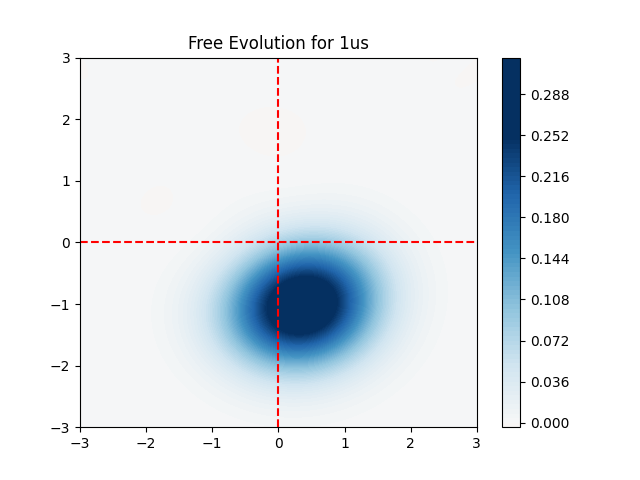

In [17]:
psi_free_evolve = rho_phonon_check

a_only = destroy(N)

H = 2 * np.pi * 1 * 10**(6) * (a_only.dag() * a_only)

t = np.linspace(0, 1*10**(-6), 101)

# ---------- Plot Wigner Function at the end of the evolution ----------#
fig, axes = plt.subplots()
output = mesolve(H = H, rho0 = psi_free_evolve, tlist = t)
rho = output.states[0]

xvec = np.linspace(-3, 3, 200)
W = wigner(rho, xvec, xvec)

axes.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')

index = [i * 5 for i in range(20)]
ims = []
for i in index:
    W = wigner(output.states[i], xvec, xvec)
    im = axes.contourf(xvec, xvec, W, 100, norm = mpl.colors.Normalize(-.25, .25), cmap = plt.get_cmap('RdBu'))
    ims.append(im.collections)

axes.set_title("Free Evolution for 1us")
axes.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
plt.colorbar(im)
ani = animation.ArtistAnimation(fig, ims, interval = 200, repeat = True)
plt.show()

We notice a slight deformation of the Gaussian Wigner distribution of a single phonon state. This is likely due to the higher-order phonon contributions.

To explain in detail: by expanding up to the 4th order, we allow for higher-order operators. As such, terms such as a^3 or a^4 are present within the Hamiltonian. While these terms are extremely far-detuned, they do minorly contribute to the evolution such that the phonon density matrix is a more complicated form than a simple coherent state.


We also double check what happens if the phase is shifted by 90 degrees:

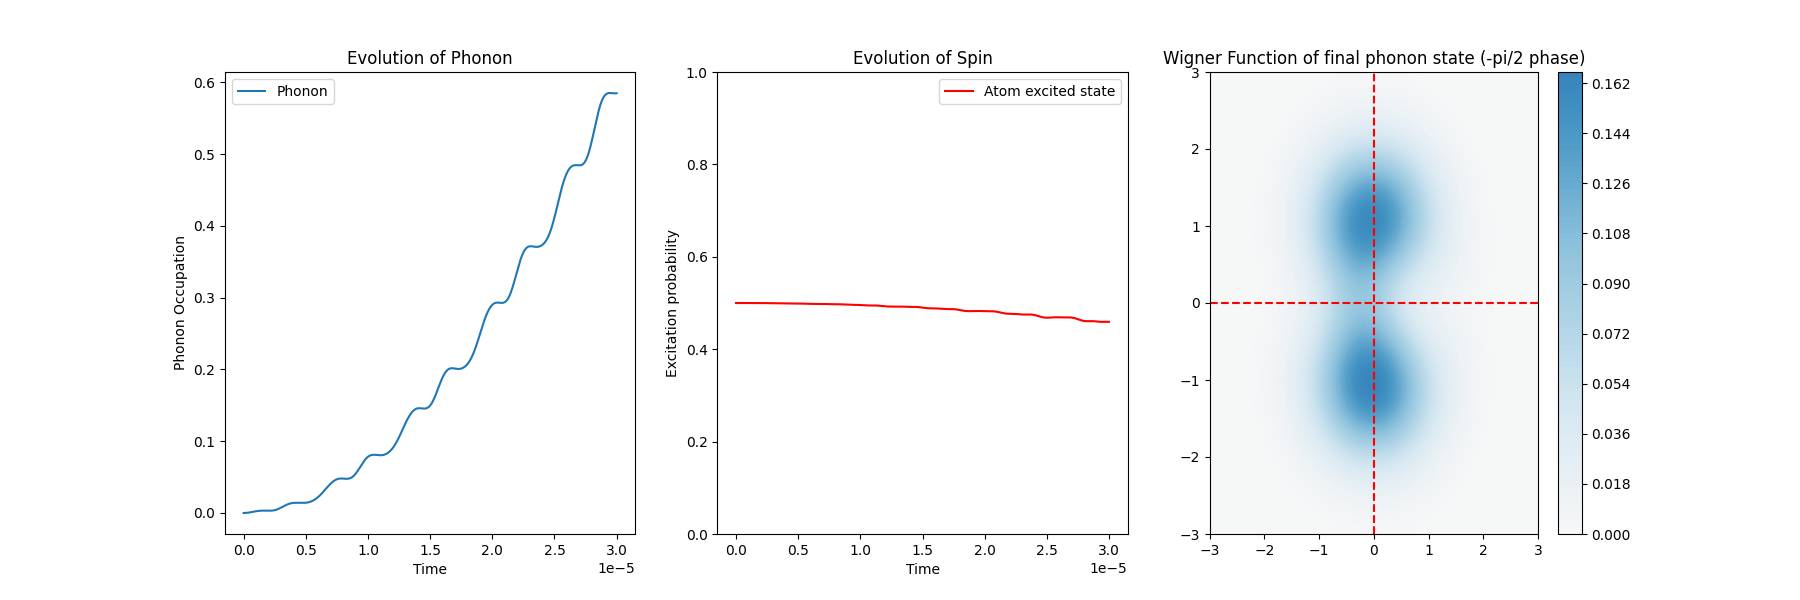

In [18]:
t = np.linspace(0, 30*10**(-6), 1001)
H = [[a_0, aoeff_0], [a_0p, aoeff_0p],
     [a_11, aoeff_11], [a_11p, aoeff_11p], [a_12, aoeff_12], [a_12p, aoeff_12p],
     [a_21, aoeff_21], [a_21p, aoeff_21p], [a_22, aoeff_22], [a_22p, aoeff_22p], [a_23, aoeff_23], [a_23p, aoeff_23p], [a_24, aoeff_24], [a_24p, aoeff_24p],
     [a_31, aoeff_31], [a_31p, aoeff_31p], [a_32, aoeff_31], [a_32p, aoeff_32p], [a_33, aoeff_33], [a_33p, aoeff_33p], [a_34, aoeff_34], [a_34p, aoeff_34p], [a_35, aoeff_35], [a_35p, aoeff_35p], [a_36, aoeff_36], [a_36p, aoeff_36p],
     [a_41, aoeff_41], [a_41p, aoeff_41p], [a_42, aoeff_42], [a_42p, aoeff_42p], [a_43, aoeff_43], [a_43p, aoeff_43p], [a_44, aoeff_44], [a_44p, aoeff_44p], [a_45, aoeff_45], [a_45p, aoeff_35p], [a_46, aoeff_46], [a_46p, aoeff_46p], [a_47, aoeff_46], [a_47p, aoeff_47p], [a_48, aoeff_48], [a_48p, aoeff_48p], [a_49, aoeff_49], [a_49p, aoeff_49p],
     [b_0, boeff_0], [b_0p, boeff_0p],
     [b_11, boeff_11], [b_11p, boeff_11p], [b_12, boeff_12], [b_12p, boeff_12p],
     [b_21, boeff_21], [b_21p, boeff_21p], [b_22, boeff_22], [b_22p, boeff_22p], [b_23, boeff_23], [b_23p, boeff_23p], [b_24, boeff_24], [b_24p, boeff_24p],
     [b_31, boeff_31], [b_31p, boeff_31p], [b_32, boeff_31], [b_32p, boeff_32p], [b_33, boeff_33], [b_33p, boeff_33p], [b_34, boeff_34], [b_34p, boeff_34p], [b_35, boeff_35], [b_35p, boeff_35p], [b_36, boeff_36], [b_36p, boeff_36p],
     [b_41, boeff_41], [b_41p, boeff_41p], [b_42, boeff_42], [b_42p, boeff_42p], [b_43, boeff_43], [b_43p, boeff_43p], [b_44, boeff_44], [b_44p, boeff_44p], [b_45, boeff_45], [b_45p, boeff_35p], [b_46, boeff_46], [b_46p, boeff_46p], [b_47, boeff_46], [b_47p, boeff_47p], [b_48, boeff_48], [b_48p, boeff_48p], [b_49, boeff_49], [b_49p, boeff_49p],
     ]

args = {"mode_freq": 1.000 * 10**(6), "detuning": 1.000 * 10**(6), "detuning2": -1.000 * 10**(6),
        "phase": 0, "phase2": 0}

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm], args = args)
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(t, n_c, label="Phonon")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Phonon Occupation")
axes[0].set_title("Evolution of Phonon")

axes[1].plot(t, n_a, 'r-', label="Atom excited state")
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Excitation probability")
axes[1].set_title("Evolution of Spin")

# Pick final state where phonon population is maximum
tt = np.where(n_c == max(n_c))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t, args = args)
rho = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon = ptrace(rho, 1)
W = wigner(rho_phonon, xvec, xvec)

im = axes[2].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[2].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[2].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[2].set_title("Wigner Function of final phonon state (-pi/2 phase)")
plt.colorbar(im)

We observe a similar 'splitting' of the displacements. In this case however, slight spin evolution is observed. I'm not exactly sure why this happens.

#### 4) Beyond LD Regime Hamiltonian

The full ion-photon interaction Hamiltonian is very hard to simulate (maybe impossible if we simply rely on the QuTip package) due to the fact that there are time-dependent, exponentiated operators. However, even without the LD approximation, it is possible to express the Hamiltonian that can be simulated on QuTip. This involves using the Zassenhaus formula to write the exponential operators as simple powers of the operators instead. The derivation is presented in my Derivation notes.

For the purposes of this simulation, we have made the arbitary choice of keeping up to the 4th order expansion, and also making use of the Rotating-Wave Approximation so that we can dump away half the resulting terms.

In [19]:
# ---------- Hamiltonians ---------- #
p = (rabi_freq / 2) * np.exp(-0.5 * ld_param**2)

# Carrier Terms (Detuning 1)
c_00 = p * sm.dag()
def coeff_00(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase'])
c_00p = p * sm
def coeff_00p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase'])

# First-Order Terms (Detuning 1)
c_10 = p * sm.dag() * a.dag()
def coeff_10(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))
c_10p = p * sm * a
def coeff_10p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))

c_01 = p * sm.dag() * a
def coeff_01(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))
c_01p = p * sm * a.dag()
def coeff_01p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))

# Second-Order Terms (Detuning 1)
c_20 = p * sm.dag() * a.dag()**2
def coeff_20(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))
c_20p = p * sm * a**2
def coeff_20p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))

c_02 = p * sm.dag() * a**2
def coeff_02(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))
c_02p = p * sm * a.dag()**2
def coeff_02p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))

c_11  = p * sm.dag() * a.dag() * a
def coeff_11(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))
c_11p = p * sm * a.dag() * a
def coeff_11p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))

# Third-Order Terms (Detuning 1):
c_30 = p * sm.dag() * a.dag()**3
def coeff_30(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))
c_30p = p * sm * a**3
def coeff_30p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))

c_03 = p * sm.dag() * a**3
def coeff_03(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))
c_03p = p * sm * a.dag()**3
def coeff_03p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))

c_12 = p * sm.dag() * a.dag() * a**2
def coeff_12(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))
c_12p = p * sm * a.dag()**2 * a
def coeff_12p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))

c_21 = p * sm.dag() * a.dag()**2 * a
def coeff_21(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 * (1j * ld_param * np.exp(-1j * args['mode_freq'] *t)) / (math.factorial(2))
c_21p = p * sm * a.dag() * a**2
def coeff_21p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 * (-1j * ld_param * np.exp(1j * args['mode_freq'] *t)) / (math.factorial(2))

# Fourth-Order Terms (Detuning 1):
c_40 = p * sm.dag() * a.dag()**4
def coeff_40(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**4 / (math.factorial(4))
c_40p = p * sm * a **4
def coeff_40p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**4 / (math.factorial(4))

c_04 = p * sm.dag() * a**4
def coeff_04(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**4 / (math.factorial(4))
c_04p = p * sm * a.dag()**4
def coeff_04p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**4 / (math.factorial(4))

c_13 = p * sm.dag() * a.dag() * a**3
def coeff_13(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))
c_13p = p * sm * a.dag()**3 * a
def coeff_13p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))

c_31 = p * sm.dag() * a.dag()**3 * a
def coeff_31(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) / (math.factorial(3))
c_31p = p * sm * a.dag() * a**3
def coeff_31p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t)) / (math.factorial(3))

c_22 = 2 * p * sm.dag() * a.dag()**2 * a**2 # Additional factor of two since there are two copies of the same thing
def coeff_22(t, args):
    return np.exp(1j * args['detuning'] * t) * np.exp(-1j * args['phase']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2) * math.factorial(2))
c_22p = 2 * p * sm * a.dag()**2 * a**2
def coeff_22p(t, args):
    return np.exp(-1j * args['detuning'] * t) * np.exp(1j * args['phase']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2) * math.factorial(2))

In [20]:
# Carrier Terms (Detuning 2)
d_00 = p * sm.dag()
def doeff_00(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2'])
d_00p = p * sm
def doeff_00p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2'])

# First-Order Terms (Detuning 1)
d_10 = p * sm.dag() * a.dag()
def doeff_10(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))
d_10p = p * sm * a
def doeff_10p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))

d_01 = p * sm.dag() * a
def doeff_01(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))
d_01p = p * sm * a.dag()
def doeff_01p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))

# Second-Order Terms (Detuning 1)
d_20 = p * sm.dag() * a.dag()**2
def doeff_20(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))
d_20p = p * sm * a**2
def doeff_20p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))

d_02 = p * sm.dag() * a**2
def doeff_02(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))
d_02p = p * sm * a.dag()**2
def doeff_02p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))

d_11  = p * sm.dag() * a.dag() * a
def doeff_11(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))
d_11p = p * sm * a.dag() * a
def doeff_11p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))

# Third-Order Terms (Detuning 1):
d_30 = p * sm.dag() * a.dag()**3
def doeff_30(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))
d_30p = p * sm * a**3
def doeff_30p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))

d_03 = p * sm.dag() * a**3
def doeff_03(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))
d_03p = p * sm * a.dag()**3
def doeff_03p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))

d_12 = p * sm.dag() * a.dag() * a**2
def doeff_12(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2))
d_12p = p * sm * a.dag()**2 * a
def doeff_12p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2))

d_21 = p * sm.dag() * a.dag()**2 * a
def doeff_21(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 * (1j * ld_param * np.exp(-1j * args['mode_freq'] *t)) / (math.factorial(2))
d_21p = p * sm * a.dag() * a**2
def doeff_21p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 * (-1j * ld_param * np.exp(1j * args['mode_freq'] *t)) / (math.factorial(2))

# Fourth-Order Terms (Detuning 1):
d_40 = p * sm.dag() * a.dag()**4
def doeff_40(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**4 / (math.factorial(4))
d_40p = p * sm * a **4
def doeff_40p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**4 / (math.factorial(4))

d_04 = p * sm.dag() * a**4
def doeff_04(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**4 / (math.factorial(4))
d_04p = p * sm * a.dag()**4
def doeff_04p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**4 / (math.factorial(4))

d_13 = p * sm.dag() * a.dag() * a**3
def doeff_13(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t)) * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 / (math.factorial(3))
d_13p = p * sm * a.dag()**3 * a
def doeff_13p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 / (math.factorial(3))

d_31 = p * sm.dag() * a.dag()**3 * a
def doeff_31(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**3 * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t)) / (math.factorial(3))
d_31p = p * sm * a.dag() * a**3
def doeff_31p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**3 * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t)) / (math.factorial(3))

d_22 = 2 * p * sm.dag() * a.dag()**2 * a**2 # Additional factor of two since there are two copies of the same thing
def doeff_22(t, args):
    return np.exp(1j * args['detuning2'] * t) * np.exp(-1j * args['phase2']) * (1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 * (1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 / (math.factorial(2) * math.factorial(2))
d_22p = 2 * p * sm * a.dag()**2 * a**2
def doeff_22p(t, args):
    return np.exp(-1j * args['detuning2'] * t) * np.exp(1j * args['phase2']) * (-1j * ld_param * np.exp(-1j * args['mode_freq'] * t))**2 * (-1j * ld_param * np.exp(1j * args['mode_freq'] * t))**2 / (math.factorial(2) * math.factorial(2))

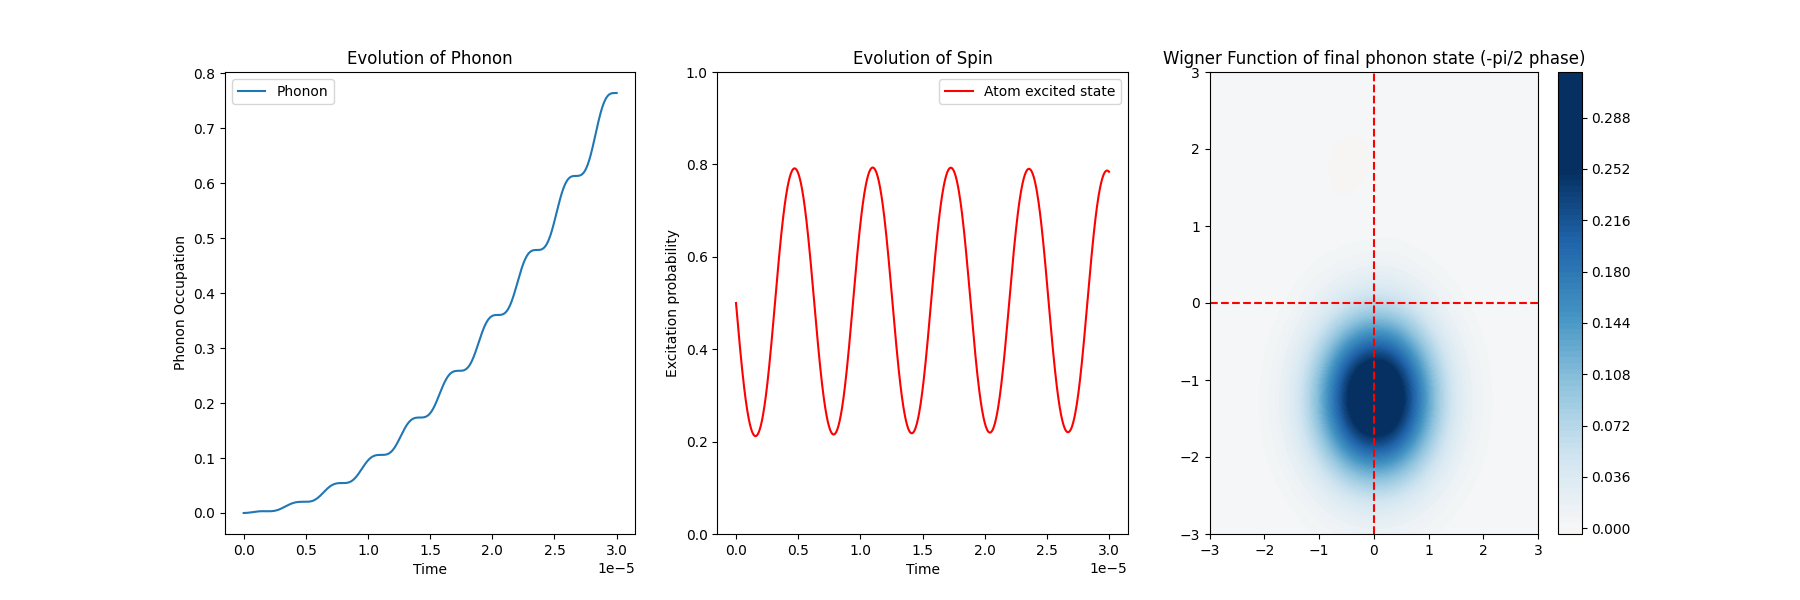

In [21]:
t = np.linspace(0, 30*10**(-6), 1001)
H = [[c_00, coeff_00], [c_00p, coeff_00p],
     [c_01, coeff_01], [c_01p, coeff_01p], [c_10, coeff_10], [c_10p, coeff_10p],
     [c_02, coeff_02], [c_02p, coeff_02p], [c_20, coeff_20], [c_20p, coeff_20p], [c_11, coeff_11], [c_11p, coeff_11p],
     [c_03, coeff_03], [c_03p, coeff_03p], [c_30, coeff_30], [c_30p, coeff_30p], [c_12, coeff_12], [c_12p, coeff_12p], [c_21, coeff_21], [c_21p, coeff_21p],
     [c_04, coeff_04], [c_04p, coeff_04p], [c_40, coeff_40], [c_40p, coeff_40p], [c_13, coeff_13], [c_13p, coeff_13p], [c_31, coeff_31], [c_31p, coeff_31p], [c_22, coeff_22], [c_22p, coeff_22p],
     [d_00, doeff_00], [d_00p, doeff_00p],
     [d_01, doeff_01], [d_01p, doeff_01p], [d_10, doeff_10], [d_10p, doeff_10p],
     [d_02, doeff_02], [d_02p, doeff_02p], [d_20, doeff_20], [d_20p, doeff_20p], [d_11, doeff_11], [d_11p, doeff_11p],
     [d_03, doeff_03], [d_03p, doeff_03p], [d_30, doeff_30], [d_30p, doeff_30p], [d_12, doeff_12], [d_12p, doeff_12p], [d_21, doeff_21], [d_21p, doeff_21p],
     [d_04, doeff_04], [d_04p, doeff_04p], [d_40, doeff_40], [d_40p, doeff_40p], [d_13, doeff_13], [d_13p, doeff_13p], [d_31, doeff_31], [d_31p, doeff_31p], [d_22, doeff_22], [d_22p, doeff_22p]
     ]

# ---------- Initial State ---------- #
psi0 = tensor(np.sqrt(2) * (basis(2 , 0) + basis (2, 1)), basis(N, 0))  # Initialise in |+> |0> state.

args = {"mode_freq": 1.000 * 10**(6), "detuning": 1.000 * 10**(6), "detuning2": -1.000 * 10**(6),
        "phase": np.pi/2, "phase2": np.pi/2}

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a, sm.dag() * sm], args = args)
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(t, n_c, label="Phonon")
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].legend()
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Phonon Occupation")
axes[0].set_title("Evolution of Phonon")

axes[1].plot(t, n_a, 'r-', label="Atom excited state")
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Excitation probability")
axes[1].set_title("Evolution of Spin")

# Pick final state where phonon population is maximum
tt = np.where(n_c == max(n_c))[0][0]

output = mesolve(H = H, rho0 = psi0, tlist = t, args = args)
rho = output.states[tt]

xvec = np.linspace(-3, 3, 200)
rho_phonon = ptrace(rho, 1)
W = wigner(rho_phonon, xvec, xvec)

im = axes[2].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes[2].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes[2].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
axes[2].set_title("Wigner Function of final phonon state (-pi/2 phase)")
plt.colorbar(im)